In [1]:
import polars as pl
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:

train_log = pl.read_parquet("../data/train_log.parquet")
test_log = pl.read_parquet("../data/test_log.parquet")
train_label = pl.read_parquet("../data/train_label_cv.parquet")
yado_df = pl.read_parquet("../data/yado.parquet")

In [3]:
# for area_group in ["wid_cd", "ken_cd", "lrg_cd", "sml_cd"]:
log = train_log
log_count = log.group_by("session_id").count().filter(pl.col("count") >0)
coappear = (log
           .filter(pl.col("session_id")
                   .is_in(log_count["session_id"]))
           .pivot(index="session_id", columns="seq_no", values="yad_no")
            .join(train_label, on="session_id")
            .to_numpy()
          )

In [4]:
coappear

array([['000007603d533d30453cc45d0f3d119f', 2395, nan, ..., nan, 4101, 0],
       ['0000ca043ed437a1472c9d1d154eb49b', 13535, nan, ..., nan, 8253,
        2],
       ['0000d4835cf113316fe447e2f80ba1c8', 123, nan, ..., nan, 4863, 4],
       ...,
       ['ffff7fb4617164b2604aaf51c40bf82d', 7183, nan, ..., nan, 13719,
        0],
       ['ffffcd5bc19d62cad5a3815c87818d83', 12230, 10619.0, ..., nan,
        10619, 3],
       ['fffffa7baf370083ebcdd98f26a7e31a', 2439, 11822.0, ..., nan,
        2439, 1]], dtype=object)

In [8]:
log_count_test = test_log.group_by("session_id").count().filter(pl.col("count") >0)
coappear_test = (test_log.filter(pl.col("session_id")
                   .is_in(log_count_test["session_id"]))
                    .pivot(index="session_id", columns="seq_no", values="yad_no")
                     .to_numpy()
)

In [9]:
print(coappear_test)

[['00001149e9c73985425197104712478c' 3560 1959.0 ... nan nan nan]
 ['0000e02747d749a52b7736dfa751e258' 11984 nan ... nan nan nan]
 ['0000f17ae2628237d78d3a38b009d3be' 757 8922.0 ... nan nan nan]
 ...
 ['ffff9a7dcc892875c7a8b821fa436228' 8989 nan ... nan nan nan]
 ['ffffb1d30300fe17f661941fd085b04b' 6030 nan ... nan nan nan]
 ['ffffe984aafd6127ce8e43e3ca40c79d' 8250 nan ... nan nan nan]]


In [15]:
train_data = np.concatenate([coappear[:, 1:-4], coappear_test[:, 1:]])

In [13]:
coappear_test[:, 1:].shape

(174700, 8)

In [26]:
train_data = [[a for a in sess if not np.isnan(a)] for sess in train_data]
fold = coappear[:, -1]
train_data = [[int(a) for a in set(sess)] for sess in train_data if len(set(sess)) > 1]
train_data = [[sess[i], sess[j]] for sess in train_data for i in range(len(sess)) for j in range(i+1, len(sess)) ]

In [27]:
train_data

[[1, 1254],
 [1, 1503],
 [1, 4133],
 [1, 5198],
 [1, 10870],
 [1, 12450],
 [1, 13754],
 [2, 3847],
 [2, 3860],
 [2, 12162],
 [2, 13783],
 [3, 846],
 [1091, 3],
 [3, 1229],
 [3, 1372],
 [3, 1779],
 [3, 2439],
 [3, 5710],
 [3, 6247],
 [3, 6524],
 [3, 6579],
 [3, 7093],
 [3, 10006],
 [3, 10095],
 [3, 10211],
 [3, 10415],
 [3, 10439],
 [3, 10556],
 [3, 11295],
 [3, 11822],
 [3, 11919],
 [3, 12350],
 [3, 12707],
 [13131, 3],
 [3, 13447],
 [3, 13524],
 [3, 13549],
 [4, 430],
 [4, 2022],
 [4, 3054],
 [4, 4829],
 [4, 9631],
 [4, 13549],
 [117, 5],
 [9493, 5],
 [10549, 5],
 [5, 12782],
 [5, 13654],
 [9, 1969],
 [9, 2750],
 [9, 3842],
 [9, 5553],
 [9, 8971],
 [9, 13001],
 [9, 13677],
 [16, 1551],
 [16, 2062],
 [16, 2756],
 [18, 3718],
 [18, 9412],
 [19, 2430],
 [21, 1469],
 [24, 385],
 [24, 1169],
 [24, 3701],
 [24, 6217],
 [24, 10857],
 [24, 12785],
 [24, 13292],
 [25, 589],
 [25, 2107],
 [25, 3077],
 [25, 4117],
 [25, 4654],
 [25, 5070],
 [25, 5521],
 [25, 5532],
 [25, 5995],
 [25, 7611],
 [25

In [30]:
fold_model = []
from gensim.models import word2vec

model = word2vec.Word2Vec(train_data, vector_size=10, window=10, epochs=1000, 
                          # sample=0.000001,
                          seed=42, 
                          # ns_exponent=0.2, 
                          # negative=10,
                          # min_count=2,
                          shrink_windows=False
                         )


In [31]:
fold_model

[]

In [32]:
import pickle 
with open("../data/item2vec/yad2vec_models.pickle", "wb") as f:
    pickle.dump(model, f)

In [69]:

yad_nos = yado_df.unique("yad_no")["yad_no"]
embbed = [{yad_no: fold_model[f].wv[yad_no] for yad_no in yad_nos.to_list() if yad_no in fold_model[f].wv} for f in range(5)]
emb_stack = np.concatenate([np.stack(list(emb.values()), axis=0) for emb in embbed], axis=0)
emb_yad = np.concatenate([list(emb.keys()) for emb in embbed], axis=0)
emb_fold = np.concatenate([[i] * len(emb) for i, emb in enumerate(embbed)])

data_dict = {
    "yad_no": emb_yad,
    "fold": emb_fold,
}
for i  in range(10):
    data_dict[f"area_emb_{i+1}"] = emb_stack[:, i]


emb_pl = pl.DataFrame(data_dict)


In [78]:
emb_pl.write_parquet("../data/item2vec/yad2vec_embs.parquet")

In [75]:
emb_pl.group_by("yad_no")

In [68]:
emb_pl.filter(pl.col("yad_no") == 96)

yad_no,fold,area_emb_1,area_emb_2,area_emb_3,area_emb_4,area_emb_5
i64,i64,f32,f32,f32,f32,f32
96,0,-1.635135,3.572837,-1.538714,4.417451,4.874539
96,1,1.724632,-0.358154,-0.842995,5.083264,5.135795
96,2,-0.519765,-3.197892,-3.166934,2.641303,4.783058
96,3,-2.574487,-0.335234,-2.012073,3.078116,5.279955
96,4,-4.250739,0.434168,0.735095,-1.166161,4.725041


In [42]:
def session_length_each_yad(log, ):

    unique_yad = log["yad_no"].unique().to_list()
    session_len = log.group_by("session_id").count()

    mean_length = []
    var_length = []
    for yad in tqdm(unique_yad):
        length = session_len.filter(pl.col("session_id").is_in(log.filter(pl.col("yad_no") == yad)["session_id"].unique().to_list()))["count"]
        mean_length.append(length.mean())
        var_length.append(length.var())

    result =  pl.DataFrame({
        "yad_no": unique_yad,
        "sess_length_mean_yad": mean_length,
        "sess_length_var_yad": var_length
    })

    result = result.with_columns([
        pl.col("sess_length_mean_yad").cast(pl.Float32),
        pl.col("sess_length_var_yad").cast(pl.Float32),
    ])

    return result
    


session_length_yad_feature = session_length_each_yad(pl.concat([train_log, test_log]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13562/13562 [02:02<00:00, 110.91it/s]


In [43]:
print(session_length_yad_feature)

shape: (13_562, 3)
┌────────┬──────────────────────┬─────────────────────┐
│ yad_no ┆ sess_length_mean_yad ┆ sess_length_var_yad │
│ ---    ┆ ---                  ┆ ---                 │
│ i64    ┆ f32                  ┆ f32                 │
╞════════╪══════════════════════╪═════════════════════╡
│ 1      ┆ 1.333333             ┆ 0.229885            │
│ 2      ┆ 1.241379             ┆ 0.189655            │
│ 3      ┆ 1.802083             ┆ 0.693608            │
│ 4      ┆ 1.809524             ┆ 0.576037            │
│ …      ┆ …                    ┆ …                   │
│ 13803  ┆ 1.368421             ┆ 0.401138            │
│ 13804  ┆ 1.569767             ┆ 0.483311            │
│ 13805  ┆ 1.5                  ┆ 0.333333            │
│ 13806  ┆ 1.675676             ┆ 0.614114            │
└────────┴──────────────────────┴─────────────────────┘


(array([6.831e+03, 4.430e+03, 1.159e+03, 2.950e+02, 7.700e+01, 3.400e+01,
        1.600e+01, 6.000e+00, 1.000e+00, 2.000e+00]),
 array([0.        , 0.30833334, 0.61666667, 0.92499995, 1.23333335,
        1.54166663, 1.8499999 , 2.1583333 , 2.4666667 , 2.77499986,
        3.08333325]),
 <BarContainer object of 10 artists>)

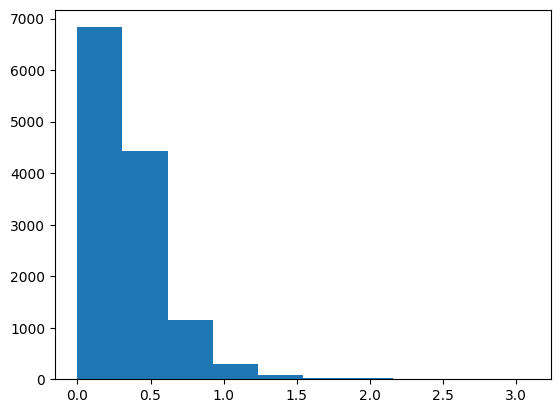

In [47]:
plt.hist(session_length_yad_feature["sess_length_var_yad"])

In [45]:
session_length_yad_feature.write_parquet("../data/features/session_length_each_yad.parquet")